Seung-Hwan Oh, Seoul, Korea

Modified by Seung-Hwan Oh 2023.10.27

Do not copy without permission


In [ ]:
코랩 -> ubuntu OS 리눅스 운영체제

In [ ]:
# 폰트 다운로드 (런타임 재부팅 해야함)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# plot 라이브러리
import matplotlib.pyplot as plt
# 경고 메시지 무시
import warnings
# 실행결과 경고메시지 출력 제외
warnings.filterwarnings('ignore')
# 글꼴 설정
plt.rc('font', family='NanumBarunGothic')

**1. 반복학습 및 loss 최저점 구하기, 조기종료**

In [ ]:
# 데이터 split하기 위한 도구
from sklearn.model_selection import train_test_split
# 데이터 고차원 화
from sklearn.preprocessing import PolynomialFeatures
# 데이터 rescaling
from sklearn.preprocessing import StandardScaler
# 사이킷런 전처리 파이프라인 만들기 위해
from sklearn.pipeline import Pipeline
# 행렬 연산 라이브러리
import numpy as np
# 사이킷런의 linear model 중 stochastic gradient descent
from sklearn.linear_model import SGDRegressor
# 사이킷런의 loss function 중 하나인 mean squared error 모듈
from sklearn.metrics import mean_squared_error

# random 기준
np.random.seed(42)

# 100개 샘플 예정
m = 100
# 100개의 랜덤 데이터
X = 6 * np.random.rand(m, 1) - 3
# 100개의 랜덤 정답값
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)
# train set, validation set
                                                        #test_size = validation set 20%, random_state suffling 기준
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

In [ ]:
# 전처리 파이프라인 polynomial Features의 차수는 2
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

In [ ]:
# X로 fitting 한다음에 변환까지
X_train_poly_scaled = poly_scaler.fit_transform(X_train)

In [ ]:
# 이미 X_train으로 poly_scaler를 fitting해서 변환만 해줌.
X_val_poly_scaled = poly_scaler.transform(X_val)

In [ ]:
import matplotlib.pyplot as plt
# SGDRegressor 모델 정의
                      # 원래는 model을 fit 할때마다 기존 학습되었던게 초기화
                      # warm start True fit 할때마다 기존 학습되었던게 "이어서" 학습할 수 잇게 된다.
                      # 이말은 즉, 누적 학습이 가능하다는거죠?
sgd_reg = SGDRegressor(max_iter=10,
                       eta0=0.0005,
                       warm_start=True,
                       random_state=42)
# 학습 횟수
n_epochs = 500
# 학습오차와 validation 오차 담을 리스트 그릇
train_errors, val_errors = [], []

# 학습 반복
for epoch in range(n_epochs):
    # fitting, polynomial 시킨거랑 정답값으로 fitting.
    sgd_reg.fit(X_train_poly_scaled, y_train)

    # fitting된 모델에 train X와 validation X 넣어서 각각 예측값 도출
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)

    # MSE 구한 후 리스트에 각각 담기
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

# argmin에서 몇번째에 val error가 낮냐? 즉 몇번째가 몇번째 epoch냐
best_epoch = np.argmin(val_errors)

# best epoch에서 val_error를 찾고, 그 값은 MSE라서 RMSE로 구함.
best_val_rmse = np.sqrt(val_errors[best_epoch])

# plot에서 설정할 값들.
# xytext : 텍스트 위치
# xy : 화살표 위치
# ha : horizontal alignment
# arrowprops : 화살표 속성들

plt.annotate('최선의 모델',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # 그래프를 더 보기 좋게 만들기 위해
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)

# val_errors와 train_errors의 RMSE
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="훈련 세트")

# 각 화살표 네이밍
plt.legend(loc="upper right", fontsize=14)

# xlabel
plt.xlabel("에포크", fontsize=14)

# ylabel
plt.ylabel("RMSE", fontsize=14)
#save_fig("early_stopping_plot")
plt.show()

In [ ]:
# SGD모델 정의
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty='l1',
                       learning_rate="constant", eta0=0.0005, random_state=42)

# infinite 값 -> 어떤 loss값이 처음에 뜰것인데,
minimum_val_error = float("inf")
best_epoch = None
count = 0

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 이어서 학습합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        count = 0
        minimum_val_error = val_error
        best_epoch = epoch
    else: # 만약에 minimun error가 연속으로 뜬다면 break를 시킬거임
        count += 1
        if count ==5:
          break


In [ ]:
print(minimum_val_error)
print(best_epoch)

**2. 로지스틱 회귀 실습**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))

# 아래 굵은선
plt.plot([-10, 10], [0, 0], "k-")
#가운데 점선
plt.plot([-10, 10], [0.5, 0.5], "k:")
#위쪽 점선
plt.plot([-10, 10], [1, 1], "k:")
#가운데 굵은선
plt.plot([0, 0], [-1.1, 1.1], "k-")

# 파란색 선
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

In [ ]:
# 사이킷런 라이브러리에서 공급하는 iris 데이터
# 총 5개의 컬럼
# sepal length in cm
# sepal width in cm
# petal length in cm
# petal width in cm
# label 버지니아, 버시컬러, 세토사

from sklearn import datasets
iris = datasets.load_iris()

In [ ]:
iris

In [ ]:
iris['data']

In [ ]:
iris['target']

In [ ]:
X = iris["data"]
X

In [ ]:
import numpy as np
# 정답 만들기, target 2부분을 1로 만드는 부분
y = (iris["target"] == 2).astype(np.int64)  # Iris-Virginica이면 1 아니면 0
y

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X, y)

In [ ]:
# 데이터 생성
# 0~3 사이에 1000개
X_new = np.linspace(0, 3, 1000).reshape(-1, 4)

# 모델로 예측 클래스가 아니라 클래스 확률을 뽑음
y_proba = log_reg.predict_proba(X_new)
y_proba



In [ ]:

# 각 데이터마다의 max 인덱스 (=클래스)를 계산
#np.argmax(y_proba,axis=1)
#print(y_proba[0])
#print(np.argmax([[0.98554411, 0.01445589]],axis=1))

In [ ]:
# 위의 기준으로 2개의 데이터를 메뉴얼하게 줘봤을시, 잘 구분하는지?
log_reg.predict([[1.7, 1, 3, 2],
                 [1.5 ,3, 1, 3]])

**3. Support Vector Machine - 분류**

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Support Vector machine classifier == SVC
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
# 총 5개의 컬럼
# sepal length in cm 꽃받침부분
# sepal width in cm 꽃받침부분
# petal length in cm 꽃잎
# petal width in cm 꽃잎
# target

X = iris["data"]

y = (iris["target"] == 2).astype(np.float64)  # 아이리스 데이터에서 타겟 2를 제외하고 라는뜻 (), 타입을 float 64
print(y)



In [ ]:
svm_clf = Pipeline([
                        # 데이터 rescaling
        ("scaler", StandardScaler()),
                        # Linear Support vector Machine Classifier: SVC, 힌지 loss
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

# SVM 훈련
svm_clf.fit(X, y)

In [ ]:
# 분류 예측
svm_clf.predict( [ [5.5, 1.7, 2.5, 1.4]] )

**3. Support Vector Machine - 비선형(Polynormial Features) 분류**

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# SVC에서 kernel을 linear로 해도 되지만, LinearSVC가 최적화 되어있고 더 빠르다
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
                          # max_iter: Gradient Descent 방식을 반복해서 몇번 수행할 것인가?
        ("svm_clf", LinearSVC(C=10, loss="hinge", max_iter=2000, random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

In [ ]:
# 분류 예측
polynomial_svm_clf.predict([[3.5, 6.4, 2.3, 2.4]])

**3. Support Vector Machine - 비선형(Polynormial Features) 분류 (Simple)**

In [ ]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, C=5))
        ])
poly_kernel_svm_clf.fit(X, y)

In [ ]:
# 분류 예측
poly_kernel_svm_clf.predict([[3.5, 6.4, 2.3, 1.5]])

**3. Support Vector Machine - 가우시안 방사함수 kernel**

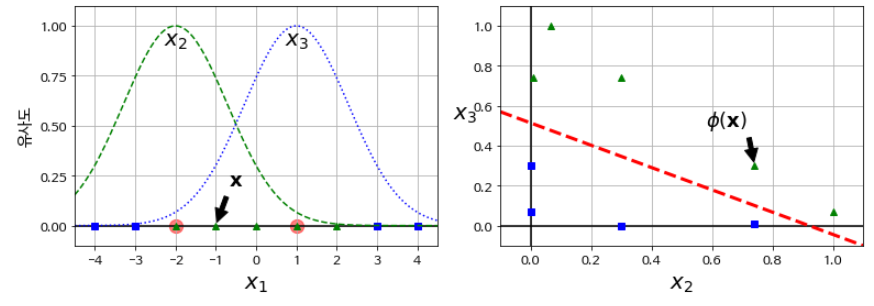

In [ ]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

**3. Support Vector Machine - 회귀**

In [ ]:
#랜덤하게 50개의 샘플 생성
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [ ]:
# Support vector regressor = SVR
from sklearn.svm import LinearSVR
                    # epsilon = 마진 강도 하이퍼 파라미터
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

In [ ]:
svm_reg.predict(X)

In [ ]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=3, epsilon=1.5)
svm_poly_reg.fit(X, y)

In [ ]:
svm_reg.predict(X)

**4. Decision Tree - 분류**

In [ ]:
from sklearn.datasets import load_iris
# Decision Tree 불러오기
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data
y = iris.target
                                # 최대 나무 깊이
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

In [ ]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(
        tree_clf,
                      # petal length, width
        feature_names=["sepal꽃잎 길이(cm)","sepal꽃잎 너비(cm)","petal 꽃잎 길이(cm)","petal꽃잎 너비(cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

In [ ]:
graph = graphviz.Source(dot_data)
graph #설명 가능한 인공지능 Explainable AI

In [ ]:
# 분류 cross validation score
from sklearn.model_selection import cross_val_score
import numpy as np
scores = cross_val_score(tree_clf, X, y, cv=5, scoring='accuracy')
np.mean(scores), scores

In [ ]:
tree_clf.predict([[5, 1.5, 1.2, 0.3]])

In [ ]:
tree_clf.feature_importances_

**4. Decision Tree - 회귀**

In [ ]:
import numpy as np
# 200개의 난수 데이터셋
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree


# 결정트리 회귀 모델
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

In [ ]:
dot_data = tree.export_graphviz(
        tree_reg,
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

In [ ]:
graph = graphviz.Source(dot_data)
graph

# x1이 만약 0.6이면 3번째 자식노드(하얀색) 노드에 해당하며
# 하얀색 노드의 value는 110개의 훈련샘플 데이터의 평균 타깃값 0.111 값을 의미.
# 결국 x1의 예측값은 0.111로 됨.
# mse는 110개 샘플에 대한

In [ ]:
# 예측 값 확인
print(tree_reg.predict([[0.65]]))
print(tree_reg.predict([[0.6]]))

In [ ]:
# 회귀 cross validation score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(-scores)

**4. Decision Tree - 실전**

In [ ]:
# 파일읽기
import pandas as pd
titanic = pd.read_csv('titanic.csv')

In [ ]:
'''
    1. PassengerId : 각 승객의 고유 번호
    2. Survived : 생존 여부(종속 변수)
        0 = 사망
        1 = 생존
    3. Pclass : 객실 등급 - 승객의 사회적, 경제적 지위
        1st = Upper
        2nd = Middle
        3rd = Lower
    4. Name : 이름
    5. Sex : 성별
    6. Age : 나이
    7. SibSp : 동반한 Sibling(형제자매)와 Spouse(배우자)의 수
    8. Parch : 동반한 Parent(부모) Child(자식)의 수
    9. Ticket : 티켓의 고유넘버
    10. Fare : 티켓의 요금
    11. Cabin : 객실 번호
    12. Embarked : 승선한 항
        C = Cherbourg
        Q = Queenstown
        S = Southampton
    '''
titanic.info()

In [ ]:
titanic.head()

In [ ]:
titanic.shape

In [ ]:
# 여자:0 남자:1로 변환
titanic.Sex = titanic.Sex.map({'female':0, 'male':1})
# 나이 누락된값 median 값으로 채움
titanic.Age.fillna(titanic.Age.median(), inplace=True)

get_dummy 함수란? - 머신러닝을 할 때 기계가 이해할 수 있도록 모든 데이터를 수치로 변환해주는 전처리 작업이 필수

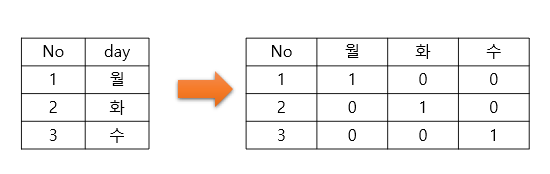

In [ ]:
# Embarked 누락값을 S로
titanic.Embarked.fillna('S', inplace=True)

# get_dummy 만들기                                   # 접두사 추가
# S 0 1
# C 0 0
# Q 1 0 로 변환
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked', drop_first=True)
embarked_dummies

In [ ]:
# 뒤에 붙여줌
titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [ ]:
titanic['S_A'] = titanic.Sex + titanic.Age
titanic.head()

In [ ]:
            # SMOTE와 카테고리변수를 고려해서 늘려주는 SMOTE-NC가 있다.
            # train데이터와  valid데이터를 나누고서 train으로만 SMOTE_NC를 해줘야한다.
from imblearn.over_sampling import SMOTE
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
# 생존 예측
y = titanic.Survived

# 모델설정
sm = SMOTE()
# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_resample(X,y)

In [ ]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()
filltered_X= rs.fit_transform(X_resampled)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(filltered_X, y_resampled)

In [ ]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(treeclf, out_file=None,
                         feature_names=feature_cols,
                         class_names=["Survived","Die"],
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
# 의사결정에 기여를 많이한 정도
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

**5. 앙상블 기법**

In [ ]:
# 통계학 상관관계 인과관계
# 선형 support vector machine,
# 다중공선성: y= w1x1 + w2x2 + w3x3 # X들끼리 강한상관 관계가 있으면 학습이 잘 안됨.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# make_moons 함수는 초승달 모양 클러스터 두 개 형상의 데이터를 생성
# n_samples : 표본 데이터의 수, 디폴트 100
# noise: 잡음의 크기. 0이면 정확한 반원을 이룸

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,recall_score,precision_score

rnd_clf = RandomForestClassifier(n_estimators=10, max_depth = 10 , random_state=42)
rnd_clf.fit(X_train, y_train)

predict_result = rnd_clf.predict(X_valid)
print(f1_score(y_valid, predict_result))
print(accuracy_score(y_valid, predict_result))
print(confusion_matrix(y_valid, predict_result))
print(recall_score(y_valid, predict_result))
print(precision_score(y_valid, predict_result))

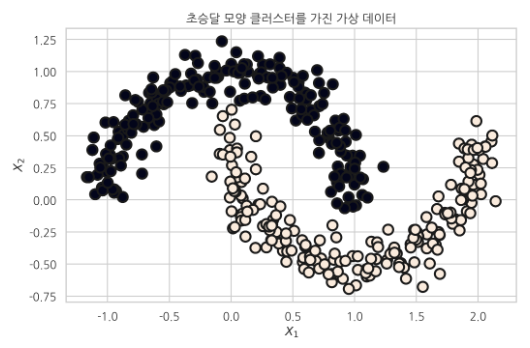

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

#투표기반 분류기
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard') # soft voting 1: [0.321, 0.5232] 2:[0.32133, 0.1221], 3:[0.21321, 0.1232321]
voting_clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)

    #모델이름, 정확도 출력
    print(clf.__class__.__name__, accuracy_score(y_valid, y_pred))

**5. 배깅 앙상블**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
                            # 무슨모델, 몇개?, cpu 사용 : -1은 전부라는 뜻
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500, n_jobs=-1,
                            random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_valid)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, y_pred))

In [ ]:
# 그냥 결정트리
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_valid)
print(accuracy_score(y_valid, y_pred_tree))

**6. AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor

# AdaBoostClassifier는 원본 에이다부스트 알고리즘의 변종인 SAMME와 SAMME.R 알고리즘을 사용
# SAMME.R이 SAMME보다 빠르고 성능도 좋다.
ada_clf = AdaBoostClassifier( DecisionTreeClassifier(max_depth=1), n_estimators=200,
                             algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
ada_clf.predict(X_valid)

**7. Gradient 부스팅 - 회귀**

In [ ]:
import numpy as np

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

X_valid = np.random.rand(100, 1) - 1.5
y_valid = 2*X[:, 0]**4 + 0.05 * np.random.randn(100)

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=42)
gbrt.fit(X, y)

predict = gbrt.predict(X_valid)
print(mean_squared_error(predict, y_valid))

**7. Gradient 부스팅 - 분류 & Grid Search**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)
model = GradientBoostingClassifier(random_state=1)

param_test = { "n_estimators": [50, 75, 100],
 "max_depth": [1, 2, 4],
  "learning_rate": [0.0001, 0.001, 0.01, 0.1],
  }
Gsearch = GridSearchCV(model, param_grid=param_test, scoring="accuracy", n_jobs=-1, cv=5 )
Gsearch.fit(X_train,y_train)
print(Gsearch.best_params_)



import joblib
joblib.dump(Gsearch, './model.pkl')

In [ ]:
loaded_model = joblib.load('./model.pkl')
loaded_model.predict(X_valid)

In [ ]:
valid_predictions = Gsearch.predict(X_valid)

In [ ]:
print("valid acc Average: ",accuracy_score(y_valid,valid_predictions))

print("valid Precision Average: ",precision_score(y_valid,valid_predictions))

print("valid Recall Average: ",recall_score(y_valid,valid_predictions))

print("valid F1_score Average: ",f1_score(y_valid,valid_predictions,average='macro'))

**7. Gradient 부스팅 - 조기종료**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

# error float타입으로 inf값으로 초기화.
min_val_error = float("inf")
error_going_up = 0

# n_estimators를 점차 늘릴때
for n_estimators in range(1, 120):

    # gbrt.n_estimators 설정
    gbrt.n_estimators = n_estimators

    # fitting
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)

    #val_error가 min_val_error보다 작을때
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        # 5번이나 연속으로 큰 에러가 나올때
        if error_going_up == 5:
            break  # 조기 종료
print("n_estimators 몇개일때:", gbrt.n_estimators)
print("MSE:", min_val_error)

**8. XGBoost - 조기종료**

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)
xgb_reg = XGBClassifier(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = accuracy_score(y_val, y_pred)
print("검증 accuracy:", val_error)

In [ ]:
                                                        #early_stopping_rounds 갯수 만큼 성능 향상이 없으면 중단
xgb_reg.fit(X_train, y_train,eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = accuracy_score(y_val, y_pred)
print("검증 accuracy:", val_error)

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

xgb_reg = CatBoostClassifier(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = accuracy_score(y_val, y_pred)
print("검증 accuracy:", val_error)

**9. Stacking**

In [ ]:
from sklearn.ensemble import  StackingClassifier
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# base_models 설정
base_models = [
       ('rf_1', RandomForestClassifier(max_depth=10)),
       ('rf_2', CatBoostClassifier(random_state=42))
      ]

# stacking 설정
clf = StackingClassifier(estimators=base_models, \
            final_estimator=GradientBoostingClassifier(max_depth=4, n_estimators=75, random_state=1))

clf.fit(X_train,y_train)

In [ ]:
test_predictions = clf.predict(X_test)

print("test acc Average: ",accuracy_score(y_test,test_predictions))

print("test Precision Average: ",precision_score(y_test,test_predictions))

print("test Recall Average: ",recall_score(y_test,test_predictions))

print("test F1_score Average: ",f1_score(y_test,test_predictions))

# AutoML - pycaret

In [ ]:
# 모델을 자동으로 돌려준다.

In [ ]:
!pip install pycaret

In [ ]:
#pycaret에서 제공하는 'juice' 데이터
from pycaret.datasets import get_data
data = get_data('juice')
#data.info()
print(data)

In [ ]:
# AutoML code
# 모델 선택할때 사용함

# 스택킹할 때 상위 몇개 골라서 사용하기 좋음
from pycaret.classification import *
setup_clf = setup(data=data, target='Purchase')
class_top = compare_models()
class_top

In [ ]:
!pip install xgboost

In [ ]:
from pycaret.regression import *
from pycaret.datasets import get_data
dataset = get_data('diamond')
exp = setup(dataset, target='Price')
reg_top = compare_models()
reg_top

In [ ]:
# pycaret 버전
import pycaret
print('PyCaret: %s' % pycaret.__version__)

In [ ]:
from pandas import read_csv
# pycaret classification 모듈
from pycaret.classification import setup
# pycaret classification 모델들을 비교하기 위한 모듈
from pycaret.classification import compare_models
# sonar 데이터셋
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv'
# 데이터셋 로드
df = read_csv(url, header=None)
# 컬럼 갯수
n_cols = df.shape[1]
# 컬럼명 String으로 반환
df.columns = [str(i) for i in range(n_cols)]
# 데이터셋 설정
grid = setup(data=df, target=df.columns[-1],  verbose=True)
# 모델 학습
best = compare_models()
# best 모델 확인
print(best)

In [ ]:
from pandas import read_csv
# pycaret classification 모듈
from pycaret.classification import setup
# pycaret classification 모델들을 비교하기 위한 모듈
from pycaret.classification import compare_models
# 데이터셋 로드
df = read_csv("titanic.csv")
# 컬럼 갯수
n_cols = df.shape[1]
# 컬럼명 String으로 반환
df.columns = [str(i) for i in range(n_cols)]
# 데이터셋 설정
grid = setup(data=df, target=df.columns[1],  verbose=True)
# 모델 학습
best = compare_models()
# best 모델 확인
print(best)

# AutoML - Autogluon

https://www.kaggle.com/datasets/parisrohan/credit-score-classification

In [ ]:
!pip install autogluon

In [ ]:
## Autoglupn이 간단한 전처리 모델링 다해줌

import pandas as pd
# Tabular Data를 다루기 때문에 아래 라이브러리를 호출
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
train_df = pd.read_csv('./train.csv').iloc[:50,:]
test_df = pd.read_csv('./test.csv').iloc[:50,:]

In [ ]:
train_df.shape

In [ ]:
# autogluon 학습을 위한 데이터 형태로 변환
train = TabularDataset(train_df.drop(['ID'], axis=1))
test = TabularDataset(test_df.drop(['ID'], axis=1))

In [ ]:
type(train)

In [ ]:
#학습
predictor = TabularPredictor(label='Credit_Score', eval_metric='f1_macro',).fit(train)

In [ ]:
# 각각의 모델의 훈련 성능을 평가할 수 있음
ld_board = predictor.leaderboard(train, silent=True)

ld_board

In [ ]:
test.columns

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
# 예측하기
pred_y = predictor.predict(train)
pred_y

In [ ]:
accuracy_score(pred_y,train['Credit_Score'])

# Hyperparameter Tuning - bayesian optimization

### 최적의 하이퍼파라미터 찾을 수 있음

In [ ]:
!pip install bayesian-optimization

In [ ]:
from sklearn.metrics import r2_score
import xgboost as xgb

# 탐색 대상 함수 (XGBRegressor)
def XGB_cv(max_depth,learning_rate, n_estimators): # bayesian에 - 옵션값을 주는 것
    # 모델 정의
    model = xgb.XGBRegressor(max_depth=int(max_depth),
                            learning_rate=learning_rate,
                            n_estimators=int(n_estimators)
                            )
    # 모델 훈련
    model.fit(X_train, y_train)
    # 예측값 출력
    y_pred= model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    # 오차 최적화로 사용할 metric 반환 (베이지안은 이것을 성능수치로 받아들이게됨)
    return r2

In [ ]:
#  bayesian-optimization 라이브러리의 BayesianOptimization 클래스 import
from bayes_opt import BayesianOptimization
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 실험해보고자하는 hyperparameter 집합
# max_depth(int, default: 3): 기본 학습자를 위한 최대 트리 깊이
# learning_rate(float, default: 0.1) : Boosting 학습률
# n_estimators(int, default: 100) : fit하기 위한 Boosted tree의 수

pbounds = {'max_depth': (3, 7),
            'learning_rate': (0.001, 0.2),
            'n_estimators': (5000, 10000)
            }

# Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )

# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10)


# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냄.
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우,
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인.

# 찾은 파라미터 값 확인
print(bo.max)

# Hyperparameter Tuning - optuna

## 옵션 값에서 minimizie? 이걸 구하기 위해사용

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost
import optuna

In [ ]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgboost.XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [ ]:
# Create the study

# 탐색스코어를 minimize되는 방향으로 탐색해라
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) # 탐색을 100번 하겠다는 뜻

In [ ]:
# best parameters
print('Best parameters', study.best_params)

# 최적의 하이퍼 파라미터 결과물

In [ ]:
model = xgboost.XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:


def test(a,b): #a,b - parameter
    print(a+b)

# 위치 인수(arguments)
# a=1
# b=2
# test(a,b)

# # 키워드 인수
# test(a=1,b=2)


# 별표 연산자 == 언팩킹 연산자.
sdict = {"a":1,"b":2}
test(**sdict) #test 함수의 파라미터에 a에 1, b에 2를 넣어준다.